In [1]:
import numpy as np
import matplotlib.pyplot as plt

import IPython
import scipy.io.wavfile as wav
import scipy.signal as ss

In [2]:
def plotSound(signal, frameRate):
    plt.plot(signal)
    plt.show()

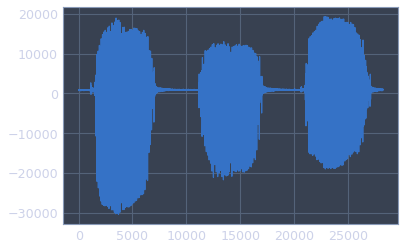

In [3]:
soundStrings =['aeiou.wav', 'an_in_on.wav']
selectedSoundString = soundStrings[1]
frameRate, frames = wav.read(selectedSoundString)
plotSound(frames, frameRate)
IPython.display.Audio(frames, rate=frameRate)

In [4]:
from math import floor, ceil

In [5]:
def nextPower(n, p):
    m = 1
    while m <= n:
        m *= p
    return m

def periode(signal, frameRate, pmin=1/300, pmax=1/80, seuil=0.7):
    signal = signal - np.mean(signal)
    N = len(signal)

    Nmin = 1 + ceil(pmin * frameRate)
    Nmax = min(1 + floor(pmax * frameRate), N)

    Nfft = nextPower(2 * N - 1, 2)
    fourierSignal = np.fft.fft(signal, n=Nfft)
    S = fourierSignal * np.conjugate(fourierSignal) / N
    r = np.real(np.fft.ifft(S))
    
    i = np.argmax(r[Nmin:Nmax])
    rmax = r[Nmin:Nmax][i]
    P = i + Nmin - 2
    corr = rmax / r[0] * N / (N-P)
    voise = corr > seuil
    if not voise:
        P = round(10e-3 * frameRate)

    return P, voise

In [6]:
def analysisPitchMarks(signal, frameRate):
    tArray = [1]
    vArray = [0]
    PArray = [10e-3 * frameRate]

    while True:
        t = tArray[-1]
        P = PArray[-1]
        duration = floor(2.5 * P)

        if t + duration > len(signal):
            break

        x = signal[t:t + duration]
        newP, voise = periode(x, frameRate)
        vArray.append(voise)
        PArray.append(newP)
        tArray.append(t + newP)
    
    A = np.zeros((3, len(tArray)))
    A[0,:] = tArray
    A[1,:] = vArray
    A[2,:] = PArray

    return A

In [7]:
A = analysisPitchMarks(frames, frameRate)
B = np.zeros((2, A.shape[1]))
B[0,:] = A[0,:]
B[1,:] = np.arange(A.shape[1])

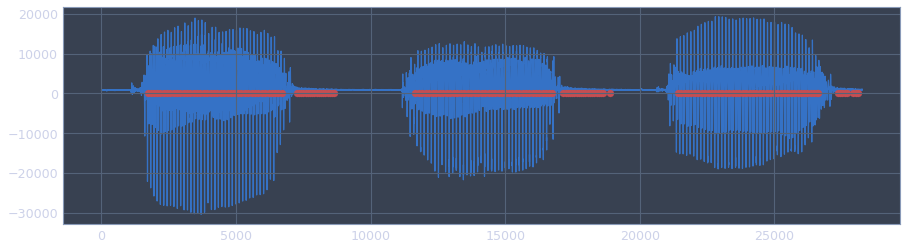

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(frames, zorder=0)
plt.scatter(A[0, np.nonzero(A[1])[0]], [0] * len(np.nonzero(A[1])[0]), c="r", s=50)
plt.show()

In [28]:
def sythesis(signal, frameRate, A, B):
    n = int(A[0,-1] + A[2,-1])
    y = np.zeros(n)
    for k in range(1, A.shape[1]):
        ta = int(A[0,k])
        P = int(A[2,k])
        ts = int(B[1,k])
        if ts+P+1 < n:
            x = signal[ta-P:ta+P+1]
            x = x * np.hanning(2*P+1)
            y[ts-P:ts+P+1] += x

    return y

In [29]:
y = sythesis(frames, frameRate, A, B)

ValueError: operands could not be broadcast together with shapes (0,) (321,) (0,) 

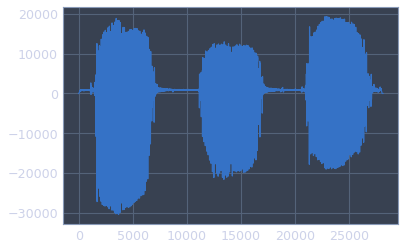

In [25]:
plotSound(y, frameRate)
IPython.display.Audio(frames, rate=frameRate)

In [33]:
def changeTimeScale(alpha, A, frameRate):
    t = np.ones(A.shape[1])
    n = np.ones(A.shape[1])

    for k in range(1, A.shape[1]):
        n[k] = n[k-1] + 1 / alpha
        t[k] = t[k-1] + A[2,int(n[k])]

    B = np.zeros((2, A.shape[1]))
    B[0,:] = np.array(t, dtype=int)
    B[1,:] = np.array(n, dtype=int)
    return B

In [34]:
def chantePitchScale(beta, A, frameRate):
    t = np.ones(A.shape[1])
    n = np.ones(A.shape[1])
    scale = np.ones(A.shape[1])

    for k in range(1, A.shape[1]):
        if A[1, int(B[1,k])]:
            scale[k] = 1 / beta
        n[k] = n[k-1] + scale[k-1]
        t[k] = t[k-1] + scale[k-1] * A[2, int(n[k])]
    
    B = np.zeros((2, A.shape[1]))
    B[0,:] = np.array(t, dtype=int)
    B[1,:] = np.array(n, dtype=int)
    return B

In [35]:
def changeBothScales(alpha, beta, A, frameRate):
    t = np.ones(A.shape[1])
    n = np.ones(A.shape[1])
    scale = np.ones(A.shape[1])

    for k in range(1, A.shape[1]):
        if A[1, int(B[1,k])]:
            scale[k] = 1 / beta
        n[k] = n[k-1] + scale[k-1] + 1 / alpha
        t[k] = t[k-1] + scale[k-1] * A[2, int(n[k])]

    B = np.zeros((2, A.shape[1]))
    B[0,:] = np.array(t, dtype=int)
    B[1,:] = np.array(n, dtype=int)
    return B